In [64]:
import torch
import gpytorch
from ASVGP.models import B1SplineMatern12ASVGP

import matplotlib.pyplot as plt

In [65]:
import torch
import gpytorch
from abc import ABC, abstractmethod
from ASVGP.basis import B1SplineBasis

class Matern12ASVGP(gpytorch.Module, ABC):
    """ """
    def __init__(self, 
                 X : torch.Tensor, 
                 y : torch.Tensor, 
                 nknots : int, 
                 alim : float, 
                 blim : float) -> 'Matern12ASVGP':
        """ """
        super().__init__()
        # parameters
        self.nknots = nknots
        self.alim = alim
        self.blim = blim
        self.mesh = torch.linspace(self.alim, self.blim, nknots)
        self.delta = self.mesh[1] - self.mesh[0]
        self.mesh = torch.concatenate(((self.mesh[0] - self.delta).unsqueeze(-1), self.mesh, (self.mesh[-1] + self.delta).unsqueeze(-1))) # add extra knots for boundary conditions
        # data
        self.train_inputs = (X,)
        self.train_targets = y
        # model components
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.mean = gpytorch.means.ZeroMean()
        self.kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1/2))
        # pre compute matrices
        # can pre-compute Kuf if you want for speed

    def non_informative_initialise(self, 
                   lmbda: float, 
                   kappa: float) -> None:
        """
        Initialises the model by setting the hyperparameters.

        Arguments:
            x_std (torch.Tensor)    : standard deviation of the input data
            y_std (torch.Tensor)    : standard deviation of the output data
            lmbda (float)           : lengthscale hyperparameter (usually in range [1, 10], where lmbda ~ 1 favours linear functions and lmbda ~ 10 gives more flexibility)
            kappa (float)           : noise hyperparameter (we expect kappa to be in the range of [2, 100], where kappa = sqrt(signal variance / noise variance)) i.e how squiggly the function is vs the variance of the residuals. Therefore large kappas mean high signal variance (very squiggly) relative to low residual variance (passing through points)
        
        Returns:
            None
        """
        # training data
        X = self.train_inputs[0]
        y = self.train_targets
        # initialise hyperparameters
        self.kernel.outputscale = y.var()
        self.likelihood.noise = self.kernel.outputscale / (kappa ** 2)
        self.kernel.base_kernel.lengthscale[0]  = (X.std() / lmbda)
    
    def informative_initialise(self,
                                prior_amplitude : float,
                                lmbda: float,) -> None:
        """
        Initialises the model hyperparameters based on prior knolwedge of the plausible function amplitudes.

        Arguments:
            prior_amplitude (float) : amplitude of the function prior
            lmbda (float)           : lengthscale hyperparameter (lambda ~ 1 -> favours linear function, lambda ~ 10 -> favours highly non-linear functions)

        Returns:
            None
        """
        # training data
        X = self.train_inputs[0]
        y = self.train_targets
        # initialise hyperparameters
        self.kernel.outputscale = (torch.tensor(prior_amplitude) / 2) ** 2
        self.likelihood.noise = y.var() - self.kernel.outputscale
        self.kernel.base_kernel.lengthscale[0]  = (X.std() / lmbda)

    @abstractmethod
    def _Kuu(self,) -> torch.Tensor:
        """ function to compute Kuu """
        pass
    
    @abstractmethod
    def _Kuf(self, 
             x : torch.Tensor) -> torch.Tensor:
        """ function to compute Kuf """
        pass

    def _sigma(self,) -> torch.Tensor:
        """ Computes [Kuu + noisesigma^{-2} Kuf Kuf^T] """
        X = self.train_inputs[0]
        # get noise sigma
        noisesigma = self.likelihood.noise[0]
        # compute matrices
        Kuu = self._Kuu()
        Kuf = self._Kuf(X)
        return Kuu + (Kuf @ Kuf.T) / noisesigma
        
    def _conditional_mu(self, 
                        x_star : torch.Tensor) -> torch.Tensor:
        """ computes noisesigma^{-2} ku()^T sigma^{-1} Kuf y """
        # training inputs
        X = self.train_inputs[0]
        # get noise sigma
        noisesigma = self.likelihood.noise[0]
        # compute matrices
        Kuf = self._Kuf(X)
        Kuf_star = self._Kuf(x_star)
        sigma = gpytorch.lazify(self._sigma())
        # compute the conditional mean
        cond_mu = (Kuf_star.T @ sigma.inv_matmul(Kuf) @ self.train_targets) / noisesigma
        return cond_mu

    def _conditional_cov(self, 
                         x_star : torch.Tensor) -> torch.Tensor:
        """ computes k(,) + ku()^T sigma^{-1} ku() - ku()^t Kuu^{-1} ku() """
        # training inputs
        X = self.train_inputs[0]
        # compute matrices
        Kuu = gpytorch.lazify(self._Kuu())
        Kuf = self._Kuf(X)
        Kuf_star = self._Kuf(x_star)
        sigma = gpytorch.lazify(self._sigma())
        # compute the terms in the conditional covariance
        term1 = self.kernel(x_star).evaluate()
        term2 = Kuf_star.T @ sigma.inv_matmul(Kuf_star)
        term3 = Kuf_star.T @ Kuu.inv_matmul(Kuf_star)
        # compute the conditional covariance
        cond_cov = term1 + term2 - term3
        return cond_cov
    
    def posterior(self, x_star : torch.Tensor) -> torch.Tensor:
        """ computes the approximate posterior distribution """
        # training inputs
        X = self.train_inputs[0]
        # get noise sigma
        noisesigma = self.likelihood.noise[0]
        # compute matrices
        Kuu = gpytorch.lazify(self._Kuu())
        Kuf = self._Kuf(X)
        Kuf_star = self._Kuf(x_star)
        sigma = gpytorch.lazify(self._sigma())
        # conditional mean
        cond_mu = (Kuf_star.T @ sigma.inv_matmul(Kuf) @ self.train_targets) / noisesigma
        # conditional covariance
        term1 = self.kernel(x_star).evaluate()
        term2 = Kuf_star.T @ sigma.inv_matmul(Kuf_star)
        term3 = Kuf_star.T @ Kuu.inv_matmul(Kuf_star)
        cond_cov = gpytorch.lazify(term1 + term2 - term3)
        # compute the approximate posterior
        posterior = gpytorch.distributions.MultivariateNormal(cond_mu, cond_cov)
        return posterior
    
    def posterior_predictive(self, x_star : torch.Tensor) -> torch.Tensor:
        """ computes the posterior predictive distribution """
        # get posterior
        posterior = self.posterior(x_star)
        # pass it through the likelihood
        posterior_predictive = self.likelihood(posterior)
        return posterior_predictive
    
    def _elbo(self,) -> torch.Tensor:
        """ """
        # training data
        X = self.train_inputs[0]
        y = self.train_targets
        # get noise sigma
        noise_sigma = self.likelihood.noise[0]
        # compute matrices
        Kuu = gpytorch.lazify(self._Kuu())
        Kuf = self._Kuf(self.train_inputs[0])
        Kff = self.kernel(self.train_inputs[0]).evaluate()
        # 'approximate prior' term
        approx_prior = Kuf.T @ Kuu.inv_matmul(Kuf)
        # evidence term
        evidence_mean = self.mean(X)
        evidence_covariance = approx_prior + (noise_sigma * torch.eye(X.size(0)))
        evidence_term = gpytorch.distributions.MultivariateNormal(evidence_mean, evidence_covariance).log_prob(y)
        # trace term
        trace_term = torch.trace(Kff - approx_prior) / (2 * noise_sigma)
        # elbo
        elbo = evidence_term - trace_term
        return elbo
    
    def fit(self, 
            niter : int, 
            learningrate : float,
            trace : bool = False) -> None:
        """ """
        # initialize optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learningrate)

        # perform gradient descent
        history = torch.empty(niter)
        for i in range(niter):
            optimizer.zero_grad()
            elbow = -self._elbo()
            history[i] = elbow.item()
            elbow.backward()
            optimizer.step()


        if trace:
            return history
        else:
            return None


In [66]:
class B1BasisFunction:

    """ Bm,1(x) basis functions for B-spline of order 1 """

    def __init__(self, 
                 m : int, 
                 vm : float, 
                 vm1 : float, 
                 vm2 : float) -> 'B1BasisFunction':
        """ Constructs the Bm,1(x) basis functions for a B-spline of order 1 """
        self.m = m
        self.vm = vm
        self.vm1 = vm1
        self.vm2 = vm2
        self.delta = vm1 - vm

    def __call__(self, x : torch.Tensor) -> torch.Tensor:
        """ Evaluates the Bm,1(x) basis functions at x according to the Cox-de Boor recursion """

        # get B_{m,0}(x) and b_{m+1,0}(x)
        B0 = torch.logical_and(x >= self.vm, x <= self.vm1) * 1
        B1 = torch.logical_and(x > self.vm1, x <= self.vm2) * 1

        return ((x - self.vm) / (self.vm1 - self.vm)) * B0 + ((self.vm2 - x) / (self.vm2 - self.vm1)) * B1

# - B-SPLINE BASIS - #
class SplineBasis(ABC):

    """ B-spline basis of order k """

    def __init__(self,
                mesh : torch.Tensor) -> 'SplineBasis':
        """ Constructs a B-spline of order k """
        # child needs to set self.order
        self.mesh = mesh
        self.m = mesh.size(0) - (self.order + 1 )
        self.delta = mesh[1] - mesh[0]
        # child needs to set self.basis

    def __call__(self, x : torch.Tensor) -> torch.Tensor:
        """ Evaluates the B-spline of order 1 at x """
        return torch.vstack([self.basis[m](x) for m in range(self.m)])
    
    @abstractmethod
    def rkhs_inner_product():
        """ Computes the RKHS inner product terms of the B-spline basis functions (excluding hyperparameters) """
        pass


class B1SplineBasis(SplineBasis):
    """ B-spline of order 1 """
    def __init__(self, mesh : torch.Tensor) -> 'B1SplineBasis':
        self.order = 1
        super().__init__(mesh)
        self.basis = [B1BasisFunction(m, self.mesh[m], self.mesh[m+1], self.mesh[m+2]) for m in range(self.m)]

    def rkhs_inner_product(self, 
                            band : int,
                            scalesigma : float, 
                            lengthscale : float) -> torch.Tensor:
        """ 
        Returns the matrices involved in the RKHS inner product (EXCLUDING HYPERPARAMETERS)
        Note: the hyperparemters featuer in the model methods _Kuu and _Kuf

        Arguments:
            band : int, the band of the matrix to return (0 for main diagonal, 1 for first upper and lower diagonal)
        
        """
        assert band in [0, 1], "band must be 0 or 1 for B-spline of order 1"

        # compute inner products
        if band == 0:
            # compute integral terms
            int1 = torch.ones(self.m) * (2. / self.delta)
            int2 = torch.ones(self.m) * ((2. / 3.) * self.delta)
            # boundary conditions
            bound_cond = torch.zeros(self.m)
            bound_cond[0] = 1.
            bound_cond[-1] = 1.
            # inner product
            inner_prod = (int1 / (2. * scalesigma)) + (int2 / (2. * lengthscale * scalesigma)) + (bound_cond / (2. * scalesigma))
            return torch.diag_embed(inner_prod.flatten(), offset=0)
        else:
            # compute integrals
            int1 = torch.ones(self.m - 1) * (-1. / self.delta)
            int2 = torch.ones(self.m - 1) * (self.delta / 6.)
            # boundary conditions
            # boundary conditions = 0!
            # inner product
            inner_prod = ((1. / (2. * scalesigma) ) * int1) + ((1 / (2. * lengthscale * scalesigma)) * int2)
            return torch.diag_embed(inner_prod, offset=1) + torch.diag_embed(inner_prod, offset=-1)




In [67]:
class B1SplineMatern12ASVGP(Matern12ASVGP):

    def __init__(self,
                 X : torch.Tensor, 
                 y : torch.Tensor, 
                 nknots : int, 
                 alim : float, 
                 blim : float) -> 'Matern12ASVGP':
        """ """
        super().__init__(X, y, nknots, alim, blim)
        self.basis = B1SplineBasis(self.mesh)

    def _Kuf(self, x) -> torch.Tensor:
        return self.basis(x)

    def _Kuu(self,) -> torch.Tensor:
        # get hyperparemters
        scalesigma = self.kernel.outputscale
        lengthscale = self.kernel.base_kernel.lengthscale[0]
        # compute inner product matrics
        diagonal = self.basis.rkhs_inner_product(band = 0, scalesigma = scalesigma, lengthscale = lengthscale)
        band1 = self.basis.rkhs_inner_product(band = 1, scalesigma = scalesigma, lengthscale = lengthscale)
        # compute Kuu
        Kuu = diagonal + band1
        return Kuu

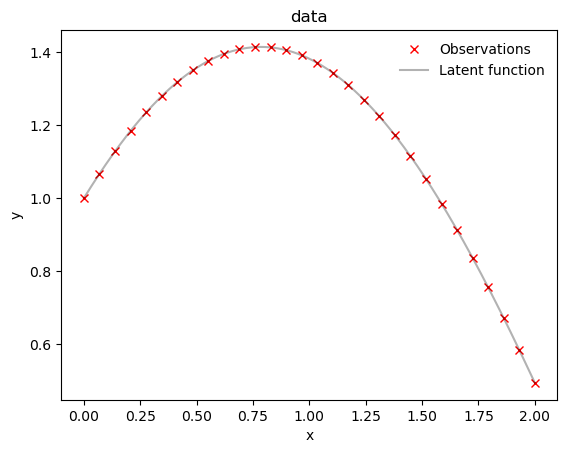

In [208]:
from utilsA import gen_1d

# generate some data
generating_function = lambda x : torch.sin(x) + torch.cos(x)

leftlim = 0.
rightlim = 2.
nobs = 30

X, y = gen_1d(generating_function, leftlim, rightlim, nobs, randomspacing=False)

plt.plot(X, y, 'x', color = 'red', label = 'Observations')
plt.plot(torch.linspace(leftlim, rightlim, 1000), generating_function(torch.linspace(leftlim, rightlim, 1000)), color = 'black', alpha = 0.3, label = 'Latent function') # true function
plt.title('data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=False)

In [209]:
asvgp = B1SplineMatern12ASVGP(X.to(torch.float64), y.to(torch.float64), 20, -1, 3.)

In [210]:
asvgp._Kuu().shape

torch.Size([20, 20])

In [211]:
asvgp.to(torch.float64);

In [212]:
LMBDA = 3.
KAPPA = 20.
asvgp.non_informative_initialise(LMBDA, KAPPA)

In [213]:
x_test = torch.linspace(leftlim, rightlim, 1000)

In [214]:
f_pred = asvgp.posterior(x_test.to(torch.float64))

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


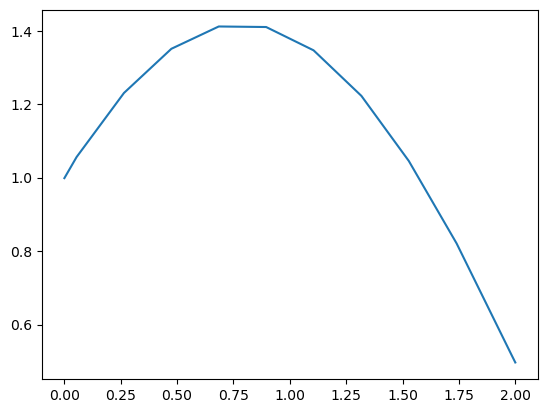

In [215]:
plt.plot(x_test, f_pred.mean.detach())

In [216]:
asvgp.to(torch.float64)

B1SplineMatern12ASVGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean): ZeroMean()
  (kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [217]:
# asvgp.likelihood.initialize(noise=1e-4);

In [218]:
trace = asvgp.fit(niter=1000, learningrate=0.01, trace=True)

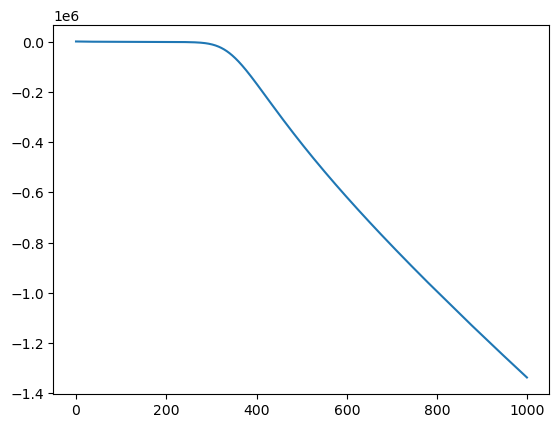

In [219]:
plt.plot(trace)

In [220]:
x_test = torch.linspace(leftlim, rightlim, 1000)
f_pred = asvgp.posterior(x_test.to(torch.float64))
upper, lower = f_pred.confidence_region()

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


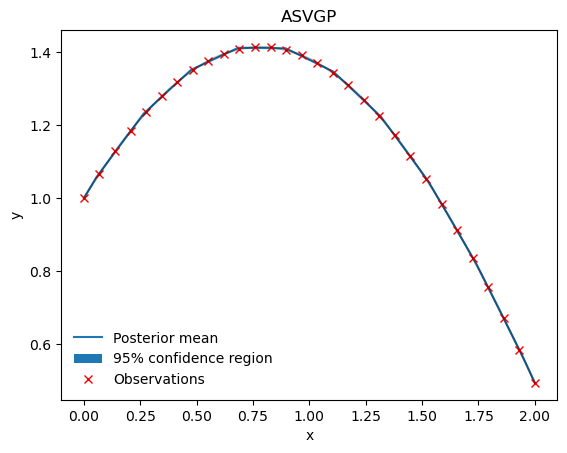

In [221]:
# posterior 
plt.plot(x_test, f_pred.mean.detach().numpy(), label = 'Posterior mean')
plt.fill_between(x_test, lower.detach().numpy(), upper.detach().numpy(), alpha=1., label = '95% confidence region')

# plot mesh on x axis
# plt.plot(asvgp.basis.mesh, torch.zeros(asvgp.basis.mesh.size(0)), 'x', color = 'black', label = 'Mesh')

# # plot basis functions
# for i in range(50):
#     plt.plot(x_test, asvgp.basis(x_test.to(torch.float64))[i].detach().numpy(), alpha=0.5)


plt.plot(X, y, 'x', color = 'red', label = 'Observations')
plt.plot(torch.linspace(leftlim, rightlim, 1000), generating_function(torch.linspace(leftlim, rightlim, 1000)), color = 'black', alpha = 0.3,) # true function

# styling
plt.title('ASVGP')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=False)

In [19]:
torch.ones(3).shape

torch.Size([3])

In [223]:
Kuu = asvgp._Kuu()
Kuf = asvgp._Kuf(X.to(torch.float64))

Text(0.5, 1.0, 'ASVGP Kuu')

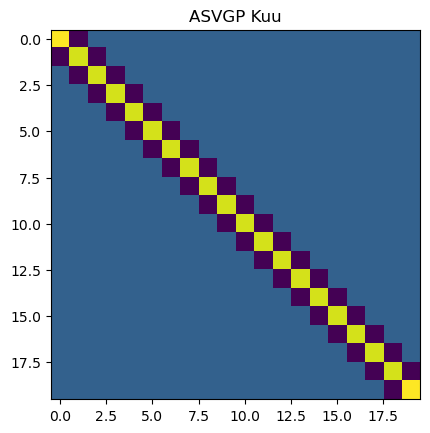

In [224]:
plt.imshow(Kuu.detach().numpy())
plt.title('ASVGP Kuu')

Text(0.5, 1.0, 'ASVGP Kuf')

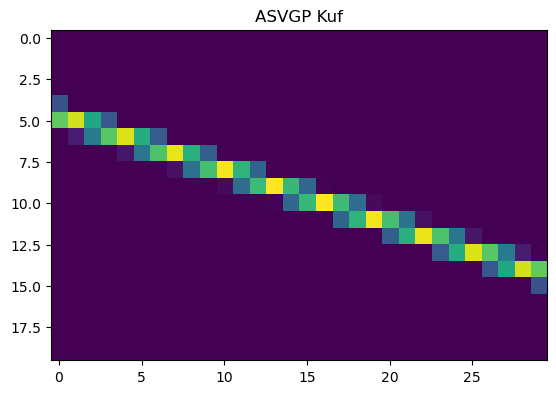

In [226]:
plt.imshow(Kuf.detach().numpy())
plt.title('ASVGP Kuf')

In [23]:
# vff import
from VFF.models import Matern12VFF1D

In [51]:
vff_gp = Matern12VFF1D(X = X.to(torch.float64), y = y.to(torch.float64), nfrequencies = 10, alim = -0.2, blim = 2.2,) 

In [52]:
vff_gp.likelihood.initialize(noise=1e-4);

In [53]:
vff_trace = vff_gp.fit(niter = 1000, learningrate = 0.01, trace = True)

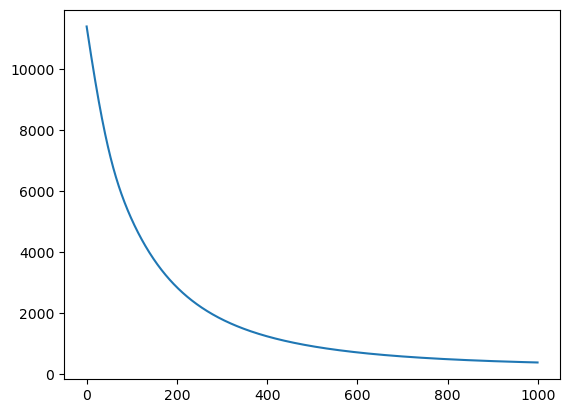

In [54]:
plt.plot(vff_trace)

In [55]:
vff_f_pred = vff_gp.posterior(x_test.to(torch.float64))
vff_upper, vff_lower = vff_f_pred.confidence_region()

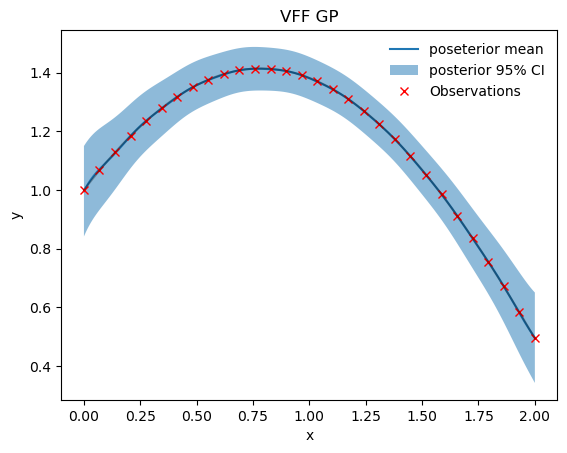

In [63]:
# posterior 
plt.plot(x_test, vff_f_pred.mean.detach().numpy(), label = 'poseterior mean')
plt.fill_between(x_test, vff_lower.detach().numpy(), vff_upper.detach().numpy(), alpha=0.5, label = 'posterior 95% CI')

# plot data
plt.plot(X, y, 'x', color = 'red', label = 'Observations')
plt.plot(torch.linspace(leftlim, rightlim, 1000), generating_function(torch.linspace(leftlim, rightlim, 1000)), color = 'black', alpha = 0.3) 

# styling
plt.title('VFF GP')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=False)

In [57]:
vff_Kuu = vff_gp._Kuu()
vff_Kuf = vff_gp._Kuf(X.to(torch.float64))

Text(0.5, 1.0, 'VFF Kuu')

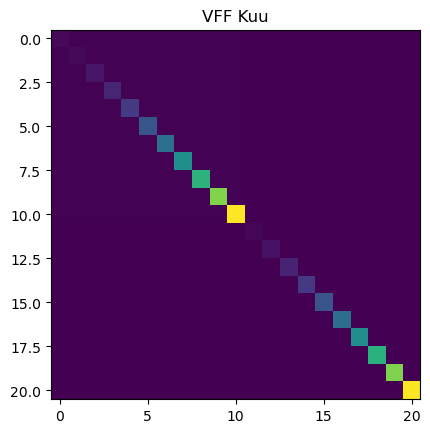

In [59]:
plt.imshow(vff_Kuu.detach().numpy())
plt.title('VFF Kuu')

Text(0.5, 1.0, 'VFF Kuf')

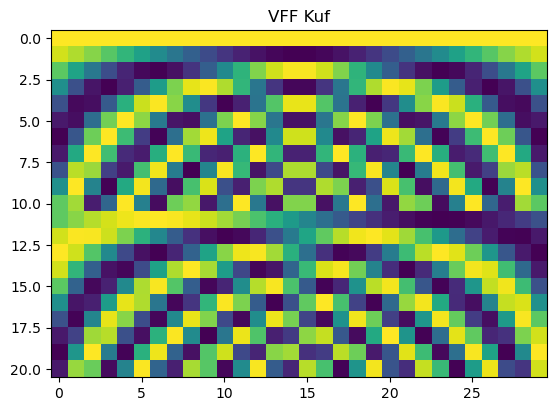

In [61]:
plt.imshow(vff_Kuf.detach().numpy())
plt.title('VFF Kuf')

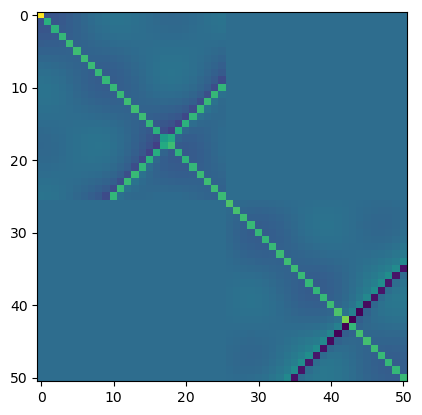

In [32]:
plt.imshow(vff_Kuf.detach().numpy() @ vff_Kuf.detach().numpy().T)
